In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

In [2]:
training_folder = "../shared_data/training_mini"

In [3]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 
# Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz)

100	 Dateien wurden geladen.


In [4]:
idx_record = 93
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaaac_s001_t000', 'aaaaaaac_s001_t001', 'aaaaaaac_s002_t000']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  400 Hz
Referenzsystem:  AR
EEG Labels: (seizure_present, onset, offset) (1, 34.8275, 63.0425)


In [5]:
# Berechne Montagen der linken und rechten Gehirnhälfte für die erste Aufnahme
new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 106000)


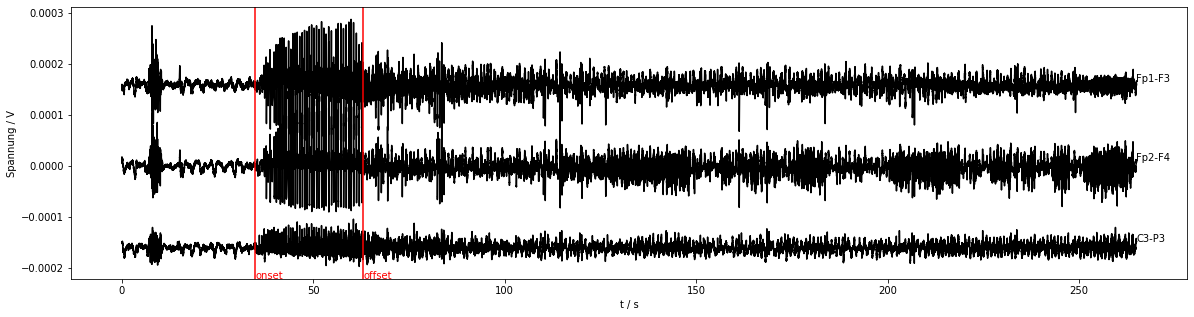

In [ ]:
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

In [ ]:
onset_list_predict = []
onset_list = []
seizure_id_list = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # Ziehe erste Montage des EEG
            signal = _montage_data[j]
            # Wende Notch-Filter an um Netzfrequenz zu dämpfen
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            
            # Berechne short time fourier transformation des Signal: signal_filtered = filtered signal of channel, fs = sampling frequency, nperseg = length of each segment
            # Output f= array of sample frequencies, t = array of segment times, Zxx = STFT of signal
            f, t, Zxx = sig.stft(signal_filter, _fs, nperseg=_fs * 3)
            # Berechne Schrittweite der Frequenz
            df = f[1] - f[0]
            # Berechne Engergie (Betrag) basierend auf Real- und Imaginärteil der STFT
            E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df

            # Erstelle neues Array in der ersten Iteration pro Patient
            if j == 0:
                # Initilisiere Array mit Energiesignal des ersten Kanals
                E_array = np.array(E_Zxx)
            else:
                # Füge neues Energiesignal zu vorhandenen Kanälen hinzu (stack it)
                E_array = np.vstack((E_array, np.array(E_Zxx)))

        # Berechne Gesamtenergie aller Kanäle für jeden Zeitpunkt
        E_total = np.sum(E_array, axis=0)
        # Berechne Stelle der maximalen Energie
        max_index = E_total.argmax()

        # Berechne "changepoints" der Gesamtenergie
        # Falls Maximum am Anfang des Signals ist muss der Onset ebenfalls am Anfang sein und wir können keinen "changepoint" berechnen
        if max_index == 0:
            onset_list_predict.append(0.0)
        else:
            # Berechne "changepoint" mit dem ruptures package
            # Setup für  "linearly penalized segmentation method" zur Detektion von changepoints im Signal mi rbf cost function
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # Berechne sortierte Liste der changepoints, pen = penalty value
            result = algo.predict(pen=10)
            #Indices sind ums 1 geshiftet
            result1 = np.asarray(result) - 1
            # Selektiere changepoints vor Maximum
            result_red = result1[result1 < max_index]
            # Falls es mindestens einen changepoint gibt nehmen wir den nächsten zum Maximum
            if len(result_red)<1:
                # Falls keine changepoint gefunden wurde raten wir, dass er "nahe" am Maximum ist
                print('No changepoint, taking maximum')
                onset_index = max_index
            else:
                # Der changepoint entspricht gerade dem Onset 
                onset_index = result_red[-1]
            # Füge Onset zur Liste der Onsets hinzu
            onset_list_predict.append(t[onset_index])

No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum


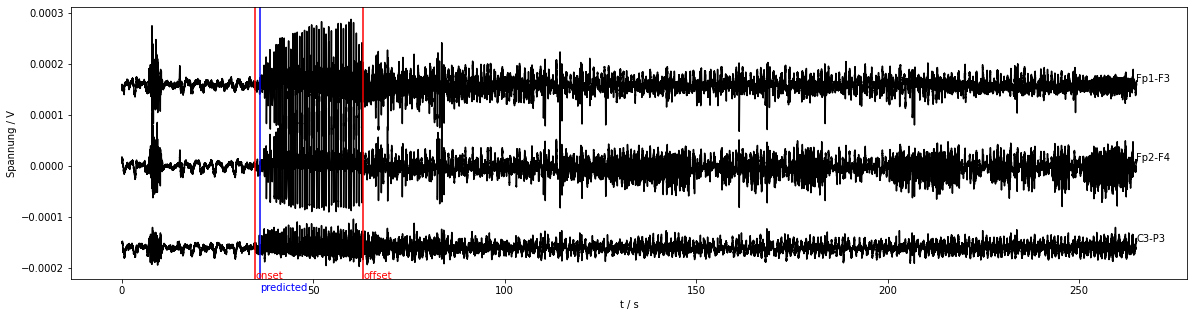

In [ ]:
fig,axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    pred_idx = seizure_id_list.index(ids[idx_record])
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')  
    plt.axvline(x = onset_list_predict[pred_idx], color = 'b', label = 'onset') 
    plt.text(onset_list_predict[pred_idx], axs.get_ylim()[0]-max_diff/10, 'predicted',color='b') 
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

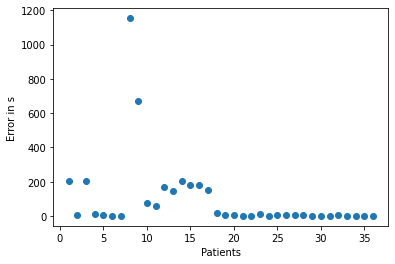

In [ ]:
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))

# Plotte Fehler als Scatterplot
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
#plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('Error in s')
plt.xlabel('Patients')
plt.show()

In [ ]:
# Seizure Detection

feature = []
label = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    label.append(_eeg_label[0])
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Wende Notch-Filter an um Netzfrequenz zu dämpfen
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        # In der Regel tritt während eines Anfalls eine höhere Standardabweichung im EEG auf
        signal_std[j] = np.std(signal_filter)

    # Nur der Kanal mit der maximalen Standardabweichung wird berücksichtigt
    signal_std_max = signal_std.max()
    feature.append(signal_std_max)
    

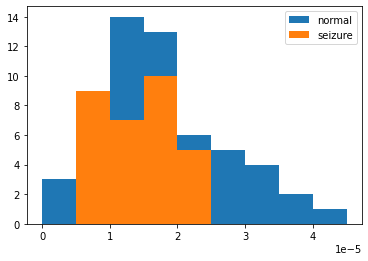

In [ ]:
# Veranschaulichung der Verteilung des Features
# Definiere Feature und Label Array
X = np.array(feature)
Y = np.array(label)
# Plotte Histogramme des Features für Normal und Anfall
bins = np.arange(0,0.00005,0.000005)
plt.figure()
plt.hist(X[(Y==0)], bins=bins)
plt.hist(X[Y==1],bins=bins)
plt.legend(['normal','seizure'])

In [ ]:
best_f1 = 0
th_opt = 0
for th in np.arange(X.min(),X.max(),(X.max()-X.min())/1e5):
    pred = X>th
    TP = np.sum((pred==Y) & (Y==1))
    FP = np.sum((pred==1) & (Y==0))
    FN = np.sum((pred==0) & (Y==1))
    F1 = 2*TP/(2*TP+FP+FN)  
    if F1 >best_f1:
        th_opt = th
        best_f1 = F1

In [ ]:
print('Optimaler Threshold ist', th_opt,' bei F1 auf Trainingsdaten von',best_f1)

Optimaler Threshold ist 4.925801507306836e-06  bei F1 auf Trainingsdaten von 0.5413533834586466


In [ ]:
python train.py
python predict_pretrained.py --test_dir ../test/
python score.py --test_dir ../test/

SyntaxError: invalid syntax (1844637412.py, line 1)

100	 Dateien wurden geladen.
Optimaler Threshold ist 4.925801507306836e-06  bei F1 auf Trainingsdaten von 0.5413533834586466
Seizure Detektionsmodell wurde gespeichert!
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
Mittlerer Onset Prädiktionsfehler Training: 97.311247222

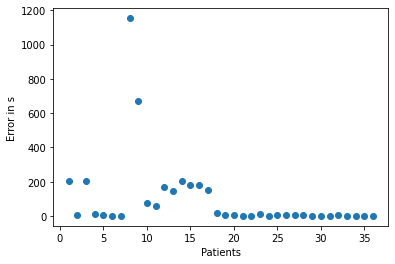

In [ ]:
# -*- coding: utf-8 -*-
"""
Beispiel Code und  Spielwiese

"""


import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt
import json


### if __name__ == '__main__':  # bei multiprocessing auf Windows notwendig

training_folder  = "../shared_data/training_mini"


ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) # Importiere EEG-Dateien, zugehörige Kanalbenennung, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz), sowie Referenzsystem



# Seizure Detektion (Der Beispielcode speichert hier ein Modell)
# Initialisiere Datenarrays
feature = []
label = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    label.append(_eeg_label[0])
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Wende Notch-Filter an um Netzfrequenz zu dämpfen
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        

        signal_std[j] = np.std(signal_filter)

    # Nur der Kanal mit der maximalen Standardabweichung wird berücksichtigt
    signal_std_max = signal_std.max()
    feature.append(signal_std_max)

X = np.array(feature)
Y = np.array(label)    
best_f1 = 0
th_opt = 0
for th in np.arange(X.min(),X.max(),(X.max()-X.min())/1e5):
    pred = X>th
    TP = np.sum((pred==Y) & (Y==1))
    FP = np.sum((pred==1) & (Y==0))
    FN = np.sum((pred==0) & (Y==1))
    F1 = 2*TP/(2*TP+FP+FN)  
    if F1 >best_f1:
        th_opt = th
        best_f1 = F1
print('Optimaler Threshold ist', th_opt,' bei F1 auf Trainingsdaten von',best_f1)

# Speichere Modell
model_params = {'std_thresh':th_opt}
with open('model.json', 'w', encoding='utf-8') as f:
    json.dump(model_params, f, ensure_ascii=False, indent=4)
    print('Seizure Detektionsmodell wurde gespeichert!')
        


# Onset Detektion (Der Beispielcode speichert hier kein Modell, da keine Parameter gelernt werden)
# Initialisiere Datenarrays
onset_list_predict = []
onset_list = []
seizure_id_list = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # Ziehe erste Montage des EEG
            signal = _montage_data[j]
            # Wende Notch-Filter an um Netzfrequenz zu dämpfen
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            
            # Berechne short time fourier transformation des Signal: signal_filtered = filtered signal of channel, fs = sampling frequency, nperseg = length of each segment
            # Output f= array of sample frequencies, t = array of segment times, Zxx = STFT of signal
            f, t, Zxx = sig.stft(signal_filter, _fs, nperseg=_fs * 3)
            # Berechne Schrittweite der Frequenz
            df = f[1] - f[0]
            # Berechne Engergie (Betrag) basierend auf Real- und Imaginärteil der STFT
            E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df

    

            # Erstelle neues Array in der ersten Iteration pro Patient
            if j == 0:
                # Initilisiere Array mit Energiesignal des ersten Kanals
                E_array = np.array(E_Zxx)
            else:
                # Füge neues Energiesignal zu vorhandenen Kanälen hinzu (stack it)
                E_array = np.vstack((E_array, np.array(E_Zxx)))
                

        # Berechne Gesamtenergie aller Kanäle für jeden Zeitppunkt
        E_total = np.sum(E_array, axis=0)
        # Berechne Stelle der maximalen Energie
        max_index = E_total.argmax()

        # Berechne "changepoints" der Gesamtenergie
        # Falls Maximum am Anfang des Signals ist muss der Onset ebenfalls am Anfang sein und wir können keinen "changepoint" berechnen
        if max_index == 0:
            onset_list_predict.append(0.0)
        else:
            # Berechne "changepoint" mit dem ruptures package
            # Setup für  "linearly penalized segmentation method" zur Detektion von changepoints im Signal mi rbf cost function
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # Berechne sortierte Liste der changepoints, pen = penalty value
            result = algo.predict(pen=10)
            #Indices sind ums 1 geshiftet
            result1 = np.asarray(result) - 1
            # Selektiere changepoints vor Maximum
            result_red = result1[result1 < max_index]
            # Falls es mindestens einen changepoint gibt nehmen wir den nächsten zum Maximum
            if len(result_red)<1:
                # Falls keine changepoint gefunden wurde raten wir, dass er "nahe" am Maximum ist
                print('No changepoint, taking maximum')
                onset_index = max_index
            else:
                # Der changepoint entspricht gerade dem Onset 
                onset_index = result_red[-1]
            # Füge Onset zur Liste der Onsets hinzu
            onset_list_predict.append(t[onset_index])

# Compute absolute error between compute seizure onset and real onset based on doctor annotations
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))
print('Mittlerer Onset Prädiktionsfehler Training:', np.mean(prediction_error))

# Plot error per patient
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
#plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('Error in s')
plt.xlabel('Patients')
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Diese Datei sollte nicht verändert werden und wird von uns gestellt und zurückgesetzt.

Skript testet das vortrainierte Modell


@author: Maurice Rohr
"""


from predict import predict_labels
from wettbewerb import EEGDataset, save_predictions
import argparse
import time

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Predict given Model')
    parser.add_argument('--test_dir', action='store',type=str,default='../test/')
    parser.add_argument('--model_name', action='store',type=str,default='model.json')
    parser.add_argument('--allow_fail',action='store_true',default=False)
    args = parser.parse_args()
    
    # Erstelle EEG Datensatz aus Ordner
    dataset = EEGDataset(args.test_dir)
    print(f"Teste Modell auf {len(dataset)} Aufnahmen")
    
    predictions = list()
    start_time = time.time()
    
    # Rufe Predict Methode für jedes Element (Aufnahme) aus dem Datensatz auf
    for item in dataset:
        id,channels,data,fs,ref_system,eeg_label = item
        try:
            _prediction = predict_labels(channels,data,fs,ref_system,model_name=args.model_name)
            _prediction["id"] = id
            predictions.append(_prediction)
        except:
            if args.allow_fail:
                raise
        
    pred_time = time.time()-start_time
    
    save_predictions(predictions) # speichert Prädiktion in CSV Datei
    print("Runtime",pred_time,"s")


usage: ipykernel_launcher.py [-h] [--test_dir TEST_DIR]
                             [--model_name MODEL_NAME] [--allow_fail]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/jupyter-wki_team_6/.local/share/jupyter/runtime/kernel-e29eda5c-8198-4e1f-9de1-6faaa77010d7.json


SystemExit: 2

/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
